# Michał Filipiuk - 385423
## SAD assignment

### Imports

In [2]:
library(car)
library(caret)
library(MASS)
library(Metrics)
library(glmnet)
library(xgboost)
require(pls)

Loading required package: carData
Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: ‘Metrics’

The following objects are masked from ‘package:caret’:

    precision, recall

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-18


Attaching package: ‘glmnet’

The following object is masked from ‘package:Metrics’:

    auc

Loading required package: pls

Attaching package: ‘pls’

The following object is masked from ‘package:caret’:

    R2

The following object is masked from ‘package:stats’:

    loadings



### Loading data

#### Cancer data - regression

In [3]:
load("cancer.RData")
cancer.data.train <- data.train
cancer.data.test <- data.test

#### Protein - regression

In [4]:
load("protein.RData")
protein.data.train <- data.frame(data.train)
protein.data.test <- data.frame(data.test)

### Data preprocessing

To analyze which columns are categorical and which are numerical, I will count the percent of unique values for each variable. If number is smaller than 1%, I'll classify it as categorical.

Cancer

In [5]:
cancer.categorical.columns <- colnames(cancer.data.train)[sapply(cancer.data.train, function(x){return(length(unique(x))/nrow(cancer.data.train)*100 < 1)})]

In [6]:
length(cancer.categorical.columns) / ncol(cancer.data.train)

[1] 0

Protein

In [7]:
protein.categorical.columns <- colnames(protein.data.train)[sapply(protein.data.train, function(x){return(length(unique(x))/nrow(protein.data.train)*100 < 1)})]

In [8]:
protein.data.train[protein.categorical.columns]  <- lapply(protein.data.train[protein.categorical.columns] , factor)
protein.data.test[protein.categorical.columns]  <- lapply(protein.data.test[protein.categorical.columns] , factor)

In [9]:
for(c in protein.categorical.columns){
    levels(protein.data.train[,c]) <- c(0,1)
    levels(protein.data.test[,c]) <- c(0,1)
}

In [10]:
length(protein.categorical.columns) / ncol(protein.data.train)

[1] 0.5002499

As we see, cancer dataset has no categorical variables, while over a half from protein are categorical

In [11]:
sum(is.na(cancer.data.train))

[1] 0

In [12]:
sum(is.na(cancer.data.test))

[1] 0

In [13]:
sum(is.na(protein.data.train))

[1] 0

In [14]:
sum(is.na(protein.data.test))

[1] 0

Perfect! Our data has no missing values!

### Building model

In [15]:
CV = function(formula, model, data, number.of.folds = 5, Y="Y"){
    fold.cut <-sample(cut(1:(dim(data)[1]), breaks = number.of.folds, labels = FALSE))
    mse.list = vector()
    for(i in 1:number.of.folds){
        train.data <- data[-(fold.cut == i), ]
        test.data <- data[(fold.cut == i), ]
        trained.model <- model(formula, data = train.data)
        x <- predict(trained.model, newdata = test.data)
        mse.list[i] <- mse(test.data$Y, x)    
    }
    print(mean(mse.list))
}

#### Protein

To solve the protein problem, I'd like to tackle it with two techniques:
- simple but quite unbreakable linear regression
- very powerful gradient boosting in form of XGBoost

##### Linear regression

Let's take a look at feature importance according to lasso

In [16]:
fit = glmnet(as.matrix(protein.data.train[, !names(protein.data.train) %in% c("Y")]), protein.data.train$Y, alpha = 1)

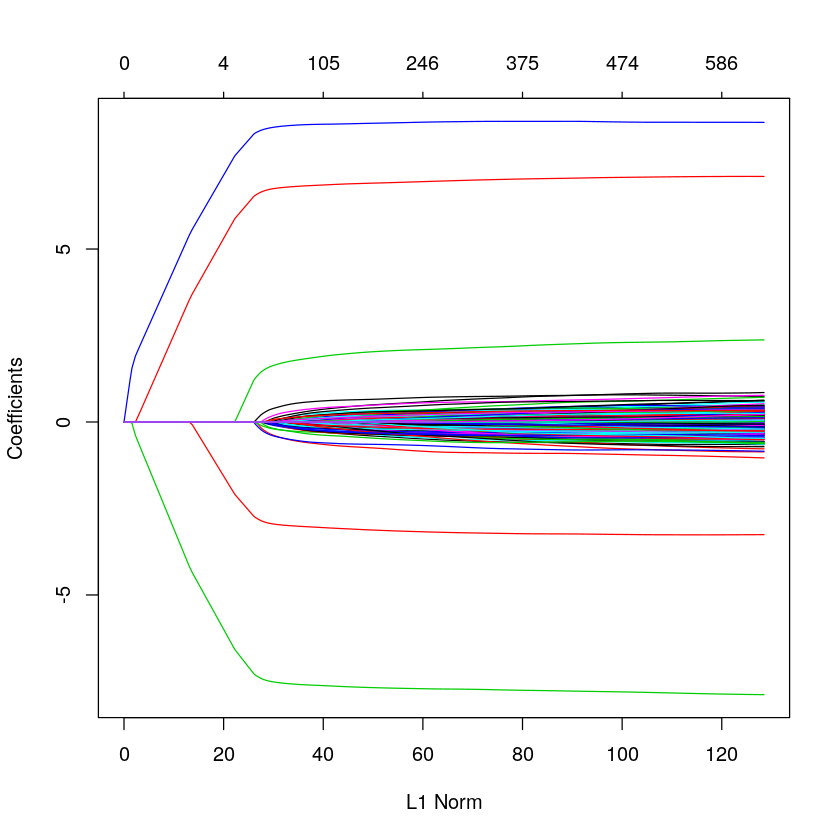

In [17]:
plot(fit)

So we have to take just 5 variables - the rest looks like a mess. Those 5 should give us a great baseline for further research

In [18]:
# here we have those 5 variables
tmp_coeffs <- coef(fit, s = fit$lambda[50])
data.frame(name = tmp_coeffs@Dimnames[[1]][tmp_coeffs@i + 1], coefficient = tmp_coeffs@x)

name,coefficient
(Intercept),15.7372053
x1623,8.2088786
x1764,6.4046415
x1028,0.9876382
x420,-7.1493013
x456,-2.6098243


In [19]:
#here we have a score (MSE) for 5-fold CV
CV(Y ~ 1 + x1623 + x1764 + x1028 + x420 + x456, data = protein.data.train, model=lm)

[1] 36.72422


In [20]:
model.protein.lm = lm(Y ~ 1 + x1623 + x1764 + x1028 + x420 + x456, data = protein.data.train,)

In [21]:
best.features.protein <- c("x1623","x1764","x1028","x420","x456")

##### XGBoost
Let's try now something different

In [22]:
dtrain <- xgb.DMatrix(data.matrix(protein.data.train[,best.features.protein]), label = protein.data.train[,"Y"])
cv <- xgb.cv(data = dtrain, nrounds = 100, nthread = 4, nfold = 5, metrics = list("rmse"),
                  max_depth = 4, eta = 0.2, lambda = 2, alpha=1, objective = "reg:linear", verbose=F)

In [23]:
cv

##### xgb.cv 5-folds
 iter train_rmse_mean train_rmse_std test_rmse_mean test_rmse_std
    1       18.794361     0.17396015      19.032747     0.7893831
    2       16.069839     0.13503564      16.577820     0.8075530
    3       13.901897     0.13487222      14.620334     0.8138235
    4       12.238312     0.14853099      13.208509     0.8208332
    5       10.906479     0.16743213      12.197169     0.8882279
    6        9.867861     0.17524460      11.407598     0.9427572
    7        9.004271     0.17216957      10.748051     1.0172270
    8        8.333926     0.18321999      10.190580     1.1131999
    9        7.768845     0.19476675       9.855870     1.1710441
   10        7.302585     0.18495575       9.554821     1.2472534
   11        6.931035     0.18725388       9.313181     1.2762016
   12        6.608239     0.17268888       9.086061     1.3180596
   13        6.341926     0.16470820       8.904235     1.3856232
   14        6.117963     0.15551729       8.752553    

As we see, XGBoost may performs well on train data, but overfits fatally on test set. Remember that its RMSE, so we have to square it (7.5^2 is more than 50 which is more than 36 on lm)

Conclusion: My model of choice for Protein data is linear regression

#### Cancer data
We start very similary - lm with lasso.  
As the cancer data has a lot of variables, we will try to attack it with PCA (unfortunately, R is a bit handicapped as I will be forced to perform PCA only on subset of data)

##### Linear regression with lasso


In [25]:
fit = cv.glmnet(data.matrix(cancer.data.train[, !names(cancer.data.train) %in% c("Y")]), cancer.data.train$Y, alpha = 1)

In [26]:
small.lambda.index <- which(sfit$lambda == fit$lambda.min)

In [27]:
tmp_coeffs <- coef(fit, s = fit$lambda[small.lambda.index])
selected.features <- tmp_coeffs@Dimnames[[1]][tmp_coeffs@i + 1][-1]

In [28]:
CV(paste("Y ~ 1 + ",paste(selected.features, collapse="+"),sep = ""), data =  cancer.data.train, model=lm)

[1] 0.005444256


In [40]:
cancer.lm.model <- lm(paste("Y ~ 1 + ",paste(selected.features, collapse="+"),sep = ""), data =  cancer.data.train)

##### PCR with linear regression

In [30]:
pcr_model <- pcr(Y~., data = cancer.data.train[,c(selected.features,'Y')], scale = TRUE, validation = "CV") # I'm forced to take only a subset of variables because of stack overflow

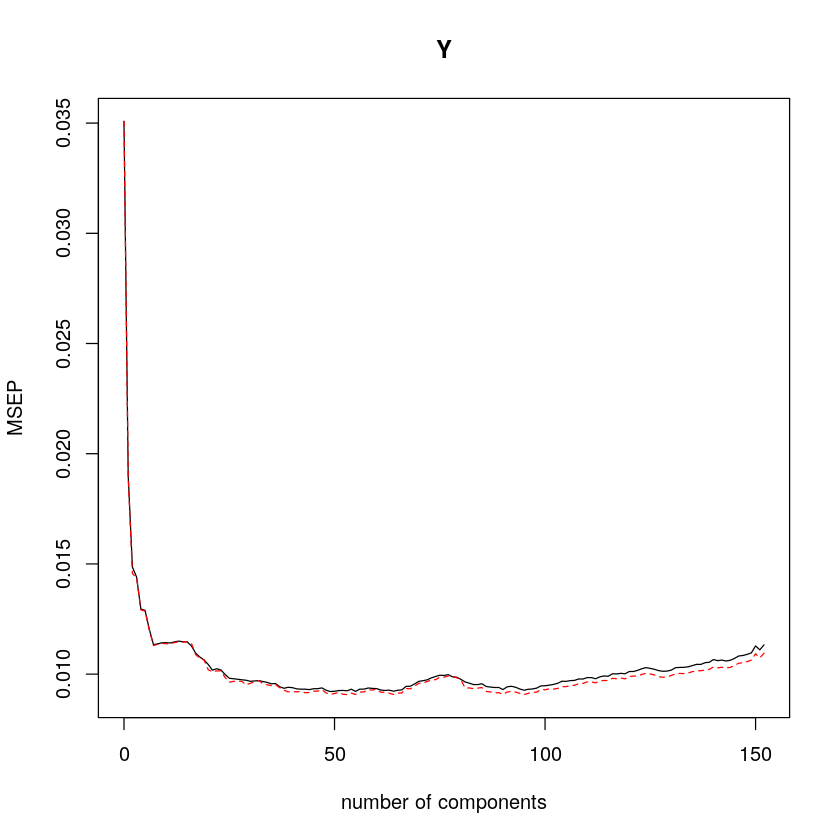

In [31]:
validationplot(pcr_model, val.type="MSEP")

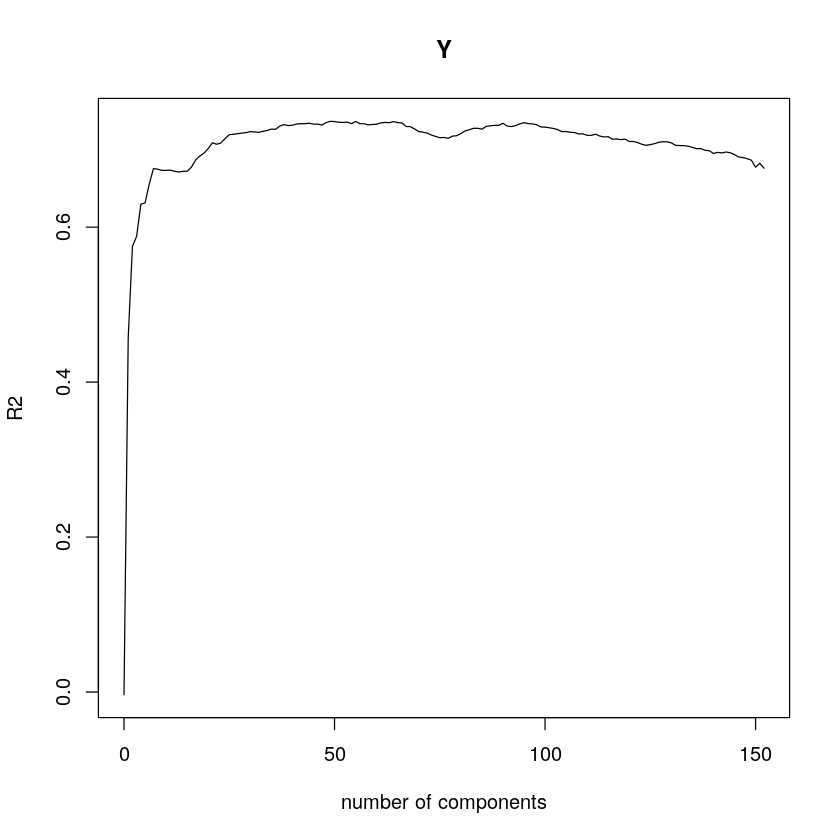

In [32]:
validationplot(pcr_model, val.type = "R2")

As we see, a linear model built on features returned from PCA is not as successful as the lasso one - here we can achieve a MSE around 0.01, while lasso yields 0.008

##### XGBoost

In [33]:
dtrain <- xgb.DMatrix(data.matrix(cancer.data.train[, !names(cancer.data.train) %in% c("Y")]), label = cancer.data.train[,"Y"])
x <- xgb.importance(model = xgboost(data = dtrain, nrounds = 100, nthread = 4, nfold = 5, metrics = list("rmse"),
                  max_depth = 5, eta = 0.2, lambda = 2, alpha=1, objective = "reg:linear", verbose=F))

In [34]:
selected.features.for.xgboost <- x[order(Gain, decreasing = T),] [1:100,]$Feature

In [35]:
dtrain <- xgb.DMatrix(data.matrix(cancer.data.train[, selected.features.for.xgboost]), label = cancer.data.train[,"Y"])
cv <- xgb.cv(data = dtrain, nrounds = 20, nthread = 4, nfold = 5, metrics = list("rmse"),
                  max_depth = 4, eta = 0.2, lambda = 2, alpha=1, objective = "reg:linear", gamma=0.1, verbose=F)

In [36]:
cv

##### xgb.cv 5-folds
 iter train_rmse_mean train_rmse_std test_rmse_mean test_rmse_std
    1       0.2979486    0.001055185      0.3019466   0.005451976
    2       0.2518810    0.001040418      0.2600392   0.006007679
    3       0.2150458    0.001122846      0.2270160   0.006715236
    4       0.1867978    0.001615148      0.2038026   0.008612723
    5       0.1633898    0.001368198      0.1852470   0.009546003
    6       0.1458516    0.001635770      0.1718580   0.011536482
    7       0.1320510    0.001710031      0.1615676   0.012393697
    8       0.1214858    0.001623737      0.1543736   0.012835493
    9       0.1131974    0.002033086      0.1486940   0.013531302
   10       0.1074924    0.002083440      0.1452806   0.014010967
   11       0.1035372    0.002124224      0.1425870   0.014753404
   12       0.1002094    0.002116772      0.1406718   0.014572030
   13       0.0979194    0.002153869      0.1393140   0.015010477
   14       0.0956806    0.001944724      0.1377296   0

### Analyzing most important variables

#### Protein
Most important features

In [37]:
print(best.features.protein)

[1] "x1623" "x1764" "x1028" "x420"  "x456" 


##### Vif

In [38]:
vif.protein <- vif(lm(Y ~ 1 + x1623 + x1764 + x1028 + x420 + x456, data = protein.data.train,))

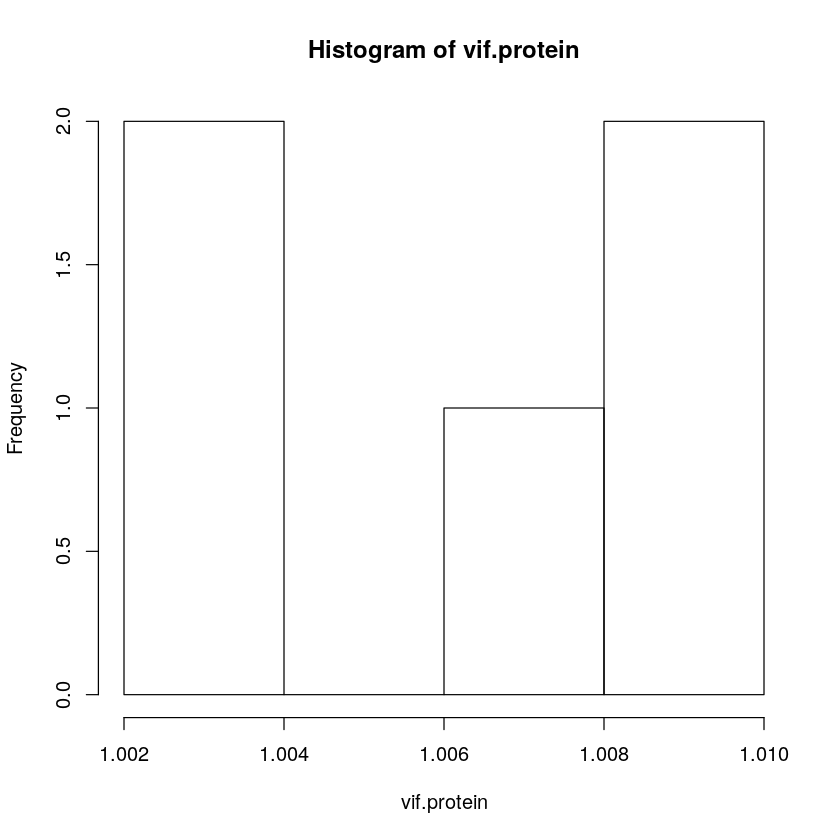

In [39]:
hist(vif.protein)

#### Cancer
Most important features

In [41]:
cancer.most.important <- names(sort(summary(cancer.lm.model)$coefficients[-1,4])[1:100])

##### Vif

In [42]:
vif.cancer <- vif(lm(paste("Y ~ 1 + ", paste(cancer.most.important, collapse="+"),sep = ""), data = cancer.data.train))

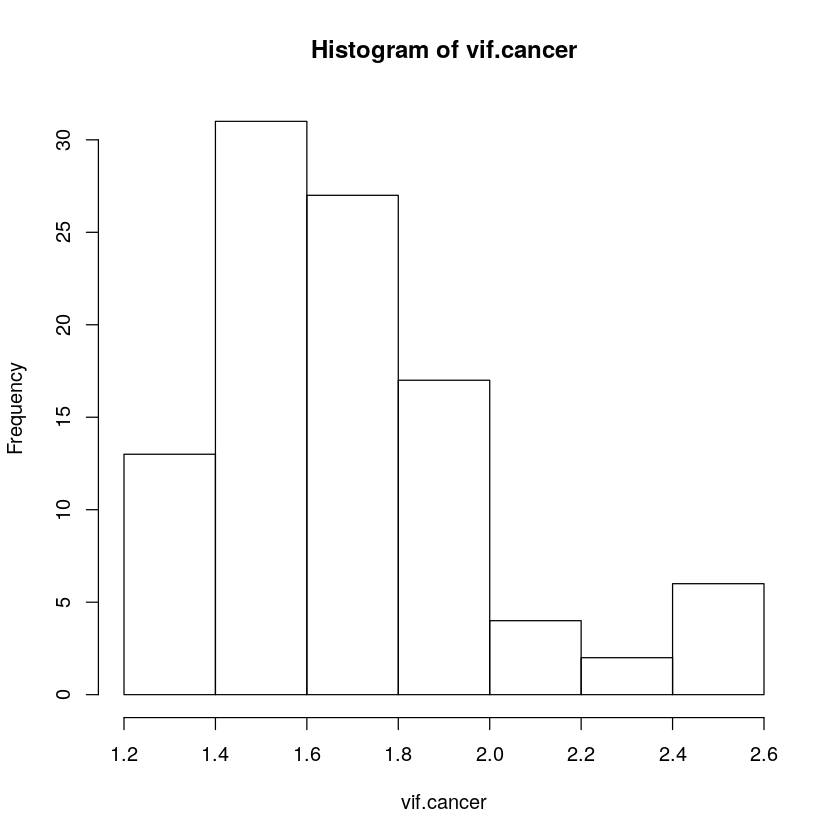

In [43]:
hist(vif.cancer)

### Saving data

In [44]:
cancer.best.model <- lm(paste("Y ~ 1 + ",paste(selected.features, collapse="+"),sep = ""), data =  cancer.data.train)
protein.best.model <- lm(Y ~ 1 + x1623 + x1764 + x1028 + x420 + x456, data = protein.data.train,)

In [45]:
cancer.Y.test <- predict(cancer.best.model, newdata = cancer.data.test)
protein.Y.test <- predict(protein.best.model, newdata = data.frame(protein.data.test))

In [46]:
pred.cancer <- cancer.Y.test
pred.protein <- protein.Y.test
predictors.protein <- best.features.protein
save(pred.cancer, pred.protein, predictors.protein, file = "filipiuk.RData")